<a href="https://colab.research.google.com/github/EnzoGolfetti/Projeto_concessao_credito_ML/blob/main/notebook_machine_learning_concessao_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desenvolvendo e selecionando o melhor modelo para o problema.

---
Este notebook é dedicado à seção de aplicação de Machine Learning para o projeto de Concessão de Crédito.

Ele usa como input o dataset pré-processado salvo no notebook de análise e pré-processamento anterior.

Logo temos nele: Features e um Target (coluna "mau")

Primeiro vamos observar e tratar o desbalanceamento do Target e em seguida aplicar os modelos para treinamento e tomada de decisão.

Volte ao notebook anterior [aqui](https://) inserir link


In [ ]:
!pip install pyforest
!pip install pycaret
!pip install scikit-learn==0.23.2 imbalanced-learn==0.7.0
!pip install lazypredict
!pip install mlxtend

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
     |████████████████████████████████| 14.8 MB 183 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.1
    Uninstalling numpy-1.19.1:
      Successfully uninstalled numpy-1.19.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lazypredict 0.2.9 requires numpy==1.19.1, but you have numpy 1.19.5 which is incompatible.
lazypredict 0.2.9 requires scikit-learn==0.23.1, but you have scikit-learn 0.23.2 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.0.5 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, b

  Using cached scikit_learn-0.23.1-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached numpy-1.19.1-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.19.1 which is incompatible.
pycaret 2.3.3 requires numpy==1.19.5, but you have numpy 1.19.1 which is incompatible.
pycaret 2.3.3 requires scikit-learn==0.23.2, but you have scikit-learn 0.23.1 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0"

In [ ]:
import pyforest #importação de mais de 40 bibliotecas populares para Data Science de forma automática
#Importando métodos do sklearn não inclusos no pyforest
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
import xgboost as xgb
import six
import sys
sys.modules["sklearn.externals.six"] = six
from mlxtend.classifier import StackingCVClassifier
#Importando os métodos de balanceamento
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
#Importando bibliotecas de busca por ML models
from lazypredict.Supervised import LazyClassifier
from pycaret.classification import *
#Importando biblioteca para exportação do model
from joblib import * 
lazy_imports()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.



['import plotly.express as px',
 'import statistics',
 'from xlrd import open_workbook',
 'from sklearn.model_selection import cross_val_score',
 'from sklearn.model_selection import GridSearchCV',
 'import matplotlib.pyplot as plt',
 'from sklearn.decomposition import PCA',
 'import datetime as dt',
 'from sklearn.linear_model import Lasso',
 'from sklearn.preprocessing import MinMaxScaler',
 'from sklearn.model_selection import RandomizedSearchCV',
 'import os',
 'from sklearn.model_selection import KFold',
 'import spacy',
 'from sklearn import metrics',
 'from sklearn.linear_model import LinearRegression',
 'import glob',
 'import altair as alt',
 'from PIL import Image',
 'from sklearn.linear_model import RidgeCV',
 'import statsmodels.api as sm',
 'from sklearn.impute import SimpleImputer',
 'import bokeh',
 'import re',
 'import pandas as pd',
 'import torch',
 'from sklearn.linear_model import LassoCV',
 'import numpy as np',
 'from sklearn.linear_model import LogisticRegressio

In [ ]:
#Lendo dataframe output preparado e clean do notebook de EDA e pre-processing
df_registro_clientes_targets = pd.read_csv('https://raw.githubusercontent.com/EnzoGolfetti/Projeto_concessao_credito_ML/main/df_registro_clientes_targets.csv',
                                           sep=',', encoding='utf-8', index_col='Unnamed: 0')
df_registro_clientes_targets.head()

,id_cliente,qtd_filhos,rendimento_anual,idade,tamanho_familia,anos_empregado,tem_carro,tem_casa_propria,tem_telefone_trabalho,tem_telefone_fixo,tem_email,categoria_de_renda,estado_civil,moradia,ocupacao,grau_escolaridade,mau
0,5008804,0,161100.0,33,2,12.4,1,1,1,0,0,Empregado,Uniao estavel,Alugado,Outros,Ensino superior,0
1,5008805,0,161100.0,33,2,12.4,1,1,1,0,0,Empregado,Uniao estavel,Alugado,Outros,Ensino superior,0
2,5008806,0,112500.0,59,2,3.1,1,1,0,0,0,Empregado,Casado,Casa propria,Seguranca,Ensino medio,0
3,5008810,0,270000.0,52,1,8.4,0,1,0,1,1,Associado comercial,Solteiro,Casa propria,Venda,Ensino medio,0
4,5008811,0,270000.0,52,1,8.4,0,1,0,1,1,Associado comercial,Solteiro,Casa propria,Venda,Ensino medio,0


In [ ]:
#Criando as listas com nomes das colunas por tipo de variável
categorical_columns = ['categoria_de_renda', 'estado_civil', 'moradia', 'ocupacao','grau_escolaridade']
cat_binary_columns = ['tem_carro', 'tem_casa_propria', 'tem_telefone_trabalho', 'tem_telefone_fixo', 'tem_email']
quant_columns = ['qtd_filhos', 'rendimento_anual', 'idade', 'tamanho_familia', 'anos_empregado']
cat_columns = categorical_columns + cat_binary_columns

In [ ]:
enc = OneHotEncoder()
scaler = MinMaxScaler()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
enc_columns = enc.fit_transform(df_registro_clientes_targets[categorical_columns]).toarray() #Uso do OneHotEncoder nas colunas categoricas
enc_columns = pd.DataFrame(enc_columns, index=df_registro_clientes_targets.index) #Transforma para DataFrame para poder concatenar no Original

In [ ]:
df_teste = pd.concat([df_registro_clientes_targets, enc_columns], axis=1)
df_teste

,id_cliente,qtd_filhos,rendimento_anual,idade,tamanho_familia,anos_empregado,tem_carro,tem_casa_propria,tem_telefone_trabalho,tem_telefone_fixo,tem_email,categoria_de_renda,estado_civil,moradia,ocupacao,grau_escolaridade,mau,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,5008804,0,161100.00,33,2,12.40,1,1,1,0,0,Empregado,Uniao estavel,Alugado,Outros,Ensino superior,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,5008805,0,161100.00,33,2,12.40,1,1,1,0,0,Empregado,Uniao estavel,Alugado,Outros,Ensino superior,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,5008806,0,112500.00,59,2,3.10,1,1,0,0,0,Empregado,Casado,Casa propria,Seguranca,Ensino medio,0,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,5008810,0,270000.00,52,1,8.40,0,1,0,1,1,Associado comercial,Solteiro,Casa propria,Venda,Ensino medio,0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
4,5008811,0,270000.00,52,1,8.40,0,1,0,1,1,Associado comercial,Solteiro,Casa propria,Venda,Ensino medio,0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23414,5149729,0,90000.00,52,2,4.70,1,1,0,0,0,Empregado,Casado,Casa propria,Outros,Ensino medio,1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
23415,5149775,0,130500.00,44,2,25.70,1,1,0,1,0,Empregado,Casado,Casa propria,Construcao Civil,Ensino medio,1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
23416,5149834,0,157500.00,34,2,3.60,0,1,0,1,1,Associado comercial,Casado,Casa propria,Medicina,Ensino superior,1,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
23417,5149838,0,157500.00,34,2,3.60,0,1,0,1,1,Pensionista,Casado,Casa propria,Medicina,Ensino superior,1,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [ ]:
df_registro_clientes_targets = df_registro_clientes_targets[['id_cliente'] + quant_columns + cat_binary_columns + categorical_columns + ['mau']]
df_registro_clientes_targets

,id_cliente,qtd_filhos,rendimento_anual,idade,tamanho_familia,anos_empregado,tem_carro,tem_casa_propria,tem_telefone_trabalho,tem_telefone_fixo,tem_email,categoria_de_renda,estado_civil,moradia,ocupacao,grau_escolaridade,mau
0,5008804,0,161100.00,33,2,12.40,1,1,1,0,0,Empregado,Uniao estavel,Alugado,Outros,Ensino superior,0
1,5008805,0,161100.00,33,2,12.40,1,1,1,0,0,Empregado,Uniao estavel,Alugado,Outros,Ensino superior,0
2,5008806,0,112500.00,59,2,3.10,1,1,0,0,0,Empregado,Casado,Casa propria,Seguranca,Ensino medio,0
3,5008810,0,270000.00,52,1,8.40,0,1,0,1,1,Associado comercial,Solteiro,Casa propria,Venda,Ensino medio,0
4,5008811,0,270000.00,52,1,8.40,0,1,0,1,1,Associado comercial,Solteiro,Casa propria,Venda,Ensino medio,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23414,5149729,0,90000.00,52,2,4.70,1,1,0,0,0,Empregado,Casado,Casa propria,Outros,Ensino medio,1
23415,5149775,0,130500.00,44,2,25.70,1,1,0,1,0,Empregado,Casado,Casa propria,Construcao Civil,Ensino medio,1
23416,5149834,0,157500.00,34,2,3.60,0,1,0,1,1,Associado comercial,Casado,Casa propria,Medicina,Ensino superior,1
23417,5149838,0,157500.00,34,2,3.60,0,1,0,1,1,Pensionista,Casado,Casa propria,Medicina,Ensino superior,1


###Aprofundando o pré-processamento dos dados e construindo a aplicação de Machine Learning

###Criando uma classe própria para um Pipeline dos modelos e primeiras aplicações de ML

---
Nesta seção construímos um Pipeline para a aplicação rápida e eficiente de uma preparação dos dados e scoring de modelos. 

Na primeira parte fazemos uma classe própria de transformador, fazemos o Pipeline e o aplicamos num def que roda os modelos e computa diversas métricas automaticamente.

Confirmaremos o desbalanceamento dos dados e vamos tratar tal problema.


In [ ]:
#Criando uma classe e um Pipeline para os modelos
class Transformer(BaseEstimator, TransformerMixin):
  def __init__(self, quant_columns, cat_columns):
    self.quant_columns = quant_columns
    self.cat_columns = cat_columns
    self.enc = OneHotEncoder()
    self.scaler = MinMaxScaler()

  def fit(self, x, y=None): #funções da classe devem ter o mesmo nome do método usado
    self.enc.fit(x[self.cat_columns])
    self.scaler.fit(x[self.quant_columns])
    return self

  def transform(self, x, y=None): #funções da classe devem ter o mesmo nome do método usado
    x_categoricals = pd.DataFrame(data=self.enc.transform(x[self.cat_columns]).toarray(),
                                  columns=self.enc.get_feature_names(self.cat_columns))
    
    x_quants = pd.DataFrame(data=self.scaler.transform(x[self.quant_columns]),
                            columns=self.quant_columns)
    
    x = pd.concat([x_quants , x_categoricals], axis=1)

    return x

In [ ]:
SEED= 98465
def roda_modelo(modelo, dados):

    # separando dados em x e y, e também removendo a coluna de ID_cliente
    x = dados.drop(['id_cliente', 'mau'], axis=1)
    y = dados['mau']
    
    # Separando dados em treino e teste
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)

    # Treinando modelo com os dados de treino
    modelo.fit(x_train, y_train)

    # Calculando a probabilidade e calculando o AUC
    prob_predic = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC {auc}")
    
    # Separando a probabilidade de ser bom e mau, e calculando o KS
    data_bom = np.sort(modelo.predict_proba(x_test)[:, 1])
    data_mau = np.sort(modelo.predict_proba(x_test)[:, 0])
    kstest = stats.ks_2samp(data_bom, data_mau)
    print(f"KS {kstest}")

    # Criando matriz de confusão
    matriz_confusao = plot_confusion_matrix(modelo, x_test, y_test, values_format='.0f', display_labels=['Bons', 'Maus'])
    plt.grid(False)    
    plt.show(matriz_confusao)

    # Fazendo a predicao dos dados de teste e calculando o classification report
    predicao = modelo.predict(x_test)
    print("\nClassification Report")
    print(classification_report(y_test, predicao, zero_division=0))

In [ ]:
dummy_classifier = DummyClassifier()
pipeline_dummy = Pipeline(steps=[("feature_transformer", Transformer(quant_columns,cat_columns)),
                           ("modelo_dummy", dummy_classifier)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.5065958878914291


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.9537147736976943, pvalue=0.0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

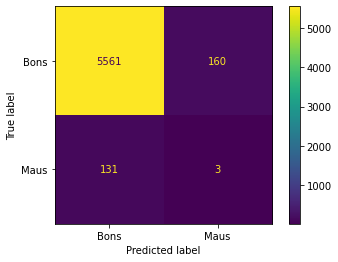


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5721
           1       0.05      0.05      0.05       134

    accuracy                           0.96      5855
   macro avg       0.51      0.51      0.51      5855
weighted avg       0.96      0.96      0.96      5855



In [ ]:
roda_modelo(pipeline_dummy, df_registro_clientes_targets)

In [ ]:
lr_model = LogisticRegression(max_iter=1000)
pipeline_lr_model = Pipeline([("feature_transformator",Transformer(quant_columns, cat_columns)),
                              ("lr_model",lr_model)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.5848712650695135


<IPython.core.display.Javascript object>

KS KstestResult(statistic=1.0, pvalue=0.0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

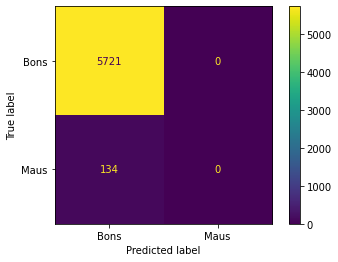


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5721
           1       0.00      0.00      0.00       134

    accuracy                           0.98      5855
   macro avg       0.49      0.50      0.49      5855
weighted avg       0.95      0.98      0.97      5855



In [ ]:
roda_modelo(pipeline_lr_model, df_registro_clientes_targets)

Como pudemos ver acima nos dois modelos, o dummy e a Logistic Regression, temos um modelo *biased* quase 100% para bons clientes. O que é péssimo para o negócio, não podemos fornecer crédito para clientes que sabemos serem ruins e irão dar *default* nos pagamentos.

##Utlizando os métodos de Undersample e Oversample para tratar o desbalanceamento do Target

Começaremos utilizando duas técnicas tradicionais de tratamento Oversampling: 
- *RandomOverSampler*, método simples que consiste em duplicar as observações da classe minoritária de forma aletatória;
- *SMOTE*, Synthetic Minority Over-sampling Technique, técnica que gera novas observações através da interposição de dados já existentes. 

In [ ]:
#Criando um objeto de RandomForestClassifier para comparar desempenho com a Logistic Regression
rf_clf_model = RandomForestClassifier()
pipeline_rf_clf_model = Pipeline([("feature_transformator",Transformer(quant_columns, cat_columns)),
                              ("rf_clf_model",rf_clf_model)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.5812971064968812


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.1842869342442357, pvalue=2.8537316242840004e-87)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

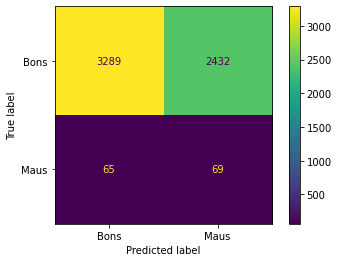


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.57      0.72      5721
           1       0.03      0.51      0.05       134

    accuracy                           0.57      5855
   macro avg       0.50      0.54      0.39      5855
weighted avg       0.96      0.57      0.71      5855



In [ ]:
ovs = RandomOverSampler(random_state=5152)
pipeline_ovs = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('ovs',ovs),("logistic_regression",lr_model)])
roda_modelo(pipeline_ovs, df_registro_clientes_targets)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.787996958051901


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.9330486763450043, pvalue=0.0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

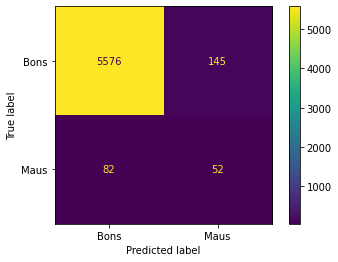


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5721
           1       0.26      0.39      0.31       134

    accuracy                           0.96      5855
   macro avg       0.62      0.68      0.65      5855
weighted avg       0.97      0.96      0.96      5855



In [ ]:
pipeline_ovs2 = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('ovs',ovs),("rf_clf_model",rf_clf_model)])
roda_modelo(pipeline_ovs2, df_registro_clientes_targets)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.5612518164291287


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.1511528608027327, pvalue=9.707019070009226e-59)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

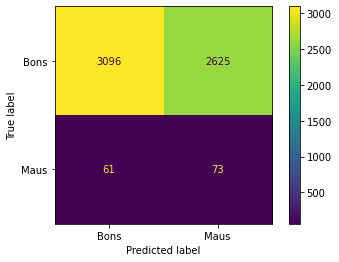


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.54      0.70      5721
           1       0.03      0.54      0.05       134

    accuracy                           0.54      5855
   macro avg       0.50      0.54      0.37      5855
weighted avg       0.96      0.54      0.68      5855



In [ ]:
smt = SMOTE(sampling_strategy='not majority', n_jobs=8)
pipeline_smt = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('smt',smt),("logistic_regression",lr_model)])
roda_modelo(pipeline_smt, df_registro_clientes_targets)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.8126638699528054


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.965670367207515, pvalue=0.0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

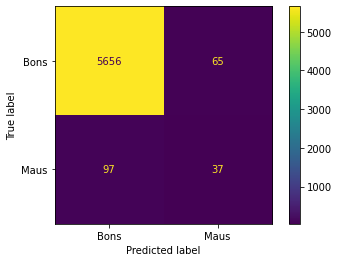


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5721
           1       0.36      0.28      0.31       134

    accuracy                           0.97      5855
   macro avg       0.67      0.63      0.65      5855
weighted avg       0.97      0.97      0.97      5855



In [ ]:
pipeline_smt2 = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('smt',smt),("rf_clf_model",rf_clf_model)])
roda_modelo(pipeline_smt2, df_registro_clientes_targets)

Utilizando as duas técnicas acima e ser realizar hiperparametrização dos algoritmos já podemos ver um incremento na qualidade, apesar dos AUC's baixos, agora o modelo tem capacidade de prever corretamente os 'maus' no dataset.

---
Vamos agora aplicar métodos de undersampling para observar os resultados.

- RandomUnderSampler: Assim como o RandomOverSampler, o método irá aleatoriamente selecionando amostras da classse majoritária para reduzi-la;
- RepeatedEditedNearestNeighbours: Método que repete diversas vezers o algoritmo ENN.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.5529347233418643


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.13151152860802734, pvalue=1.5805942048847062e-44)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

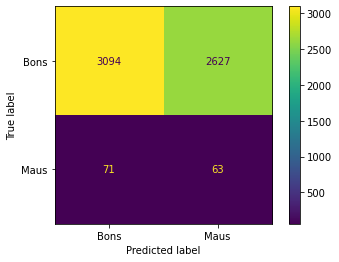


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.54      0.70      5721
           1       0.02      0.47      0.04       134

    accuracy                           0.54      5855
   macro avg       0.50      0.51      0.37      5855
weighted avg       0.96      0.54      0.68      5855



In [ ]:
#RandomUnderSampler - under sampling randomizado
uns = RandomUnderSampler(random_state=6510350)
pipeline_uns = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('uns',uns),("logistic_regression",lr_model)])
roda_modelo(pipeline_uns, df_registro_clientes_targets)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.7253272181306367


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.3496157130657558, pvalue=7.201274e-318)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

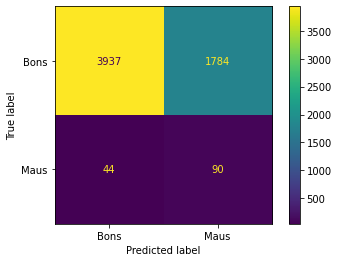


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      5721
           1       0.05      0.67      0.09       134

    accuracy                           0.69      5855
   macro avg       0.52      0.68      0.45      5855
weighted avg       0.97      0.69      0.80      5855



In [ ]:
pipeline_uns2 = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('uns',uns),("rf_clf_model",rf_clf_model)])
roda_modelo(pipeline_uns2, df_registro_clientes_targets)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.5841812176662571


<IPython.core.display.Javascript object>

KS KstestResult(statistic=1.0, pvalue=0.0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

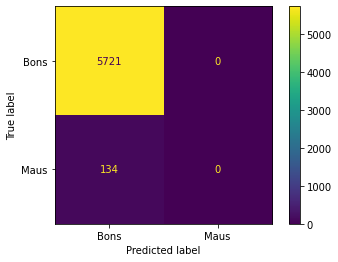


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5721
           1       0.00      0.00      0.00       134

    accuracy                           0.98      5855
   macro avg       0.49      0.50      0.49      5855
weighted avg       0.95      0.98      0.97      5855



In [ ]:
renn = RepeatedEditedNearestNeighbours(max_iter=1000)
pipeline_renn = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('renn',renn),("logistic_regression",lr_model)])
roda_modelo(pipeline_renn, df_registro_clientes_targets)

Para nossa surpresa apesar da sofisticação do modelo RENN, sua performance foi semelhance a se tivéssemos simplesmente aplicado a Regressão Logística.

---
Ainda buscando melhores performances vamos utilizar métodos **combinados** e depois **ensembled** de sampling e observar os resultados.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.5575067765524762


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.15046968403074296, pvalue=3.273705940313759e-58)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

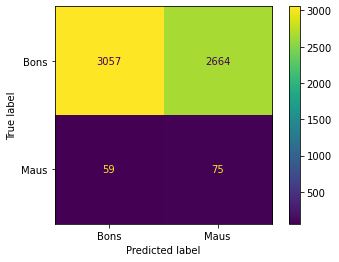


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.53      0.69      5721
           1       0.03      0.56      0.05       134

    accuracy                           0.53      5855
   macro avg       0.50      0.55      0.37      5855
weighted avg       0.96      0.53      0.68      5855



In [ ]:
smk = SMOTETomek(random_state=89456) #combinação de under e over sample, entender melhor sobre
pipeline_smk = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('smk',smk),("logistic_regression",lr_model)])
roda_modelo(pipeline_smk, df_registro_clientes_targets)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.8080624668998999


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.9637916310845431, pvalue=0.0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

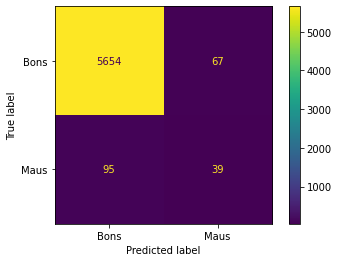


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5721
           1       0.37      0.29      0.33       134

    accuracy                           0.97      5855
   macro avg       0.68      0.64      0.66      5855
weighted avg       0.97      0.97      0.97      5855



In [ ]:
pipeline_smk2 = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('smk',smk),("rf_clf_model",rf_clf_model)])
roda_modelo(pipeline_smk2, df_registro_clientes_targets)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.7672583594873039


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.4763450042698548, pvalue=0.0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

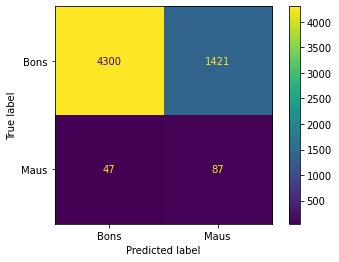


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      5721
           1       0.06      0.65      0.11       134

    accuracy                           0.75      5855
   macro avg       0.52      0.70      0.48      5855
weighted avg       0.97      0.75      0.84      5855



In [ ]:
#Ensembled Method
b_rf_clf = BalancedRandomForestClassifier(random_state=8012587)
pipeline_b_rf_clf = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('b_rf_clf',b_rf_clf)])
roda_modelo(pipeline_b_rf_clf, df_registro_clientes_targets)

Nessa primeira avaliação, já identificamos que a realização de Oversampling nos dados e a utilização do ensemble method 'BalancedRandomForestClassifier' realmente proporcionaram ganhos de perfomance para os modelos e começaram a fazer com que eles identifiquem os 'maus' pagadores que como já explicitado nas notas sobre PDD são muito importante de serem evitados.

#Aplicação de métodos de busca automática por bons modelos e hiperparametrização

---
Nesta seção iremos explorar duas bibliotecas de busca por modelos que melhor performem em nossos dados:

- Lazypredict - biblioteca mais simples que simplesmente roda vários algoritmos de uma só vez, computa e plota as melhores métricas para comparação;
- Pycaret - biblioteca *low_code* completa para Machine Learning, com apenas algumas linhas de código ela é capaz de realizar todo o pipeline de Machine Learning no dataset e testar vários modelos e métricas de uma só vez, possibilita inclusive salvar os modelos output de seu processo.


In [ ]:
SEED_2 = 9821300
model_clf_lazy_predict = LazyClassifier()
def roda_lazy_predict(model, data, imb_learn_model):

  x = data.drop(['id_cliente', 'mau'], axis=1)
  y = data['mau']

  enc.fit(x[cat_columns])
  scaler.fit(x[quant_columns])

  x_categoricals = pd.DataFrame(data=enc.transform(x[cat_columns]).toarray(),
                                  columns=enc.get_feature_names(cat_columns))
  x_quants = pd.DataFrame(data=scaler.transform(x[quant_columns]),
                            columns=quant_columns)
  x = pd.concat([x_quants,x_categoricals], axis=1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED_2)

  x_res_train, y_res_train = imb_learn_model.fit_resample(x_train, y_train)
  
  models,predictions = model_clf_lazy_predict.fit(x_res_train, x_test, y_res_train, y_test)
  print(models)

In [ ]:
#Lazy_predict com técnica SMOTE
roda_lazy_predict(model_clf_lazy_predict, df_registro_clientes_targets, smt)
roda_lazy_predict(model_clf_lazy_predict, df_registro_clientes_targets, smk)
roda_lazy_predict(model_clf_lazy_predict, df_registro_clientes_targets, uns)

Infelizmente, devido as limitaçõs de memória do Google Colab, a aplicação de técnicas de balanceamento combinadas com o uso do Lazy_predict consumiram toda a RAM disponível em todas as tentativas realizadas (9 vezes).

Essa é uma crítica feita na comunidade em geral, de que a biblioteca não contempla processamento em paralelo dos algoritmos, diminuindo a performance. 

Assim, seguiremos adiante com a aplicação da biblioteca pycaret.

In [ ]:
repeated_stratified_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=84563)
pycaret_clf_2 = setup(df_registro_clientes_targets.drop(columns=['id_cliente']), target="mau", session_id=456, log_experiment=True, experiment_name='pycaret_clf_1',
                      categorical_features=categorical_columns, numeric_features=quant_columns, remove_multicollinearity=True, 
                      multicollinearity_threshold=0.95, feature_selection=True, feature_selection_threshold=0.8, fix_imbalance=True, 
                      fix_imbalance_method=smk, data_split_shuffle=True, data_split_stratify=True, fold_strategy=repeated_stratified_kfold)

,Description,Value
0,session_id,456
1,Target,mau
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(23419, 17)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.98,0.67,0.20,0.49,0.28,0.27,0.30,6.96
lightgbm,Light Gradient Boosting Machine,0.98,0.67,0.16,0.49,0.23,0.23,0.26,2.17
rf,Random Forest Classifier,0.97,0.74,0.20,0.39,0.26,0.25,0.27,3.30
gbc,Gradient Boosting Classifier,0.97,0.62,0.05,0.26,0.08,0.07,0.10,7.43
et,Extra Trees Classifier,0.97,0.72,0.23,0.37,0.28,0.27,0.28,3.17
dt,Decision Tree Classifier,0.97,0.61,0.23,0.25,0.24,0.22,0.22,1.02
ada,Ada Boost Classifier,0.96,0.57,0.05,0.08,0.06,0.04,0.04,2.48
knn,K Neighbors Classifier,0.89,0.67,0.35,0.08,0.13,0.09,0.13,1.34
lda,Linear Discriminant Analysis,0.63,0.58,0.48,0.03,0.06,0.01,0.03,1.12
ridge,Ridge Classifier,0.63,0.00,0.48,0.03,0.06,0.01,0.03,0.92


Nessa primeira parte criamos a configuração básica do Pycaret e rodamos os vários modelos de classificação disponíveis na biblioteca.

Agora iremos criar os objetos dos melhores e apronfudá-los.

In [ ]:
#Criando os modelos
xgb_model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.97,0.71,0.16,0.36,0.22,0.21,0.23
1,0.98,0.75,0.21,0.53,0.30,0.30,0.33
2,0.98,0.72,0.19,0.47,0.27,0.26,0.29
3,0.98,0.66,0.21,0.76,0.33,0.33,0.40
4,0.98,0.71,0.20,0.50,0.29,0.28,0.31
5,0.98,0.71,0.25,0.56,0.35,0.34,0.37
6,0.98,0.72,0.20,0.62,0.30,0.30,0.35
7,0.98,0.69,0.23,0.49,0.31,0.30,0.32
8,0.98,0.74,0.17,0.57,0.27,0.26,0.30
9,0.98,0.68,0.19,0.48,0.27,0.26,0.29


In [ ]:
rf_clf = create_model('rf', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.97,0.74,0.17,0.36,0.23,0.22,0.24
1,0.97,0.74,0.19,0.39,0.25,0.24,0.26
2,0.98,0.75,0.21,0.46,0.29,0.28,0.30
3,0.98,0.75,0.17,0.45,0.25,0.24,0.27
4,0.97,0.77,0.20,0.38,0.26,0.25,0.26
5,0.97,0.74,0.21,0.40,0.28,0.27,0.28
6,0.97,0.78,0.16,0.36,0.22,0.21,0.23
7,0.97,0.73,0.24,0.39,0.30,0.29,0.29
8,0.97,0.69,0.21,0.40,0.28,0.27,0.28
9,0.97,0.76,0.20,0.37,0.26,0.25,0.26


In [ ]:
lda_clf = create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.61,0.60,0.51,0.03,0.06,0.01,0.04
1,0.60,0.61,0.56,0.03,0.06,0.02,0.05
2,0.63,0.57,0.47,0.03,0.06,0.01,0.03
3,0.61,0.58,0.52,0.03,0.06,0.01,0.04
4,0.65,0.53,0.37,0.02,0.05,0.00,0.01
5,0.62,0.60,0.55,0.03,0.06,0.02,0.05
6,0.61,0.57,0.47,0.03,0.05,0.01,0.02
7,0.66,0.55,0.41,0.03,0.05,0.01,0.03
8,0.62,0.58,0.48,0.03,0.05,0.01,0.03
9,0.63,0.63,0.49,0.03,0.06,0.01,0.04


In [ ]:
dt_clf = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.96,0.60,0.23,0.22,0.22,0.20,0.20
1,0.96,0.64,0.29,0.23,0.26,0.24,0.24
2,0.97,0.62,0.27,0.26,0.26,0.25,0.25
3,0.97,0.60,0.21,0.25,0.23,0.21,0.21
4,0.96,0.65,0.32,0.27,0.29,0.27,0.28
5,0.97,0.64,0.31,0.28,0.29,0.28,0.28
6,0.96,0.61,0.24,0.23,0.24,0.22,0.22
7,0.97,0.64,0.29,0.28,0.28,0.27,0.27
8,0.96,0.62,0.27,0.23,0.25,0.23,0.23
9,0.96,0.60,0.21,0.20,0.21,0.19,0.19


In [ ]:
lr_model_clf = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.55,0.44,0.39,0.02,0.04,-0.01,-0.02
1,0.52,0.45,0.39,0.02,0.04,-0.01,-0.03
2,0.47,0.48,0.51,0.02,0.04,-0.00,-0.01
3,0.43,0.49,0.51,0.02,0.04,-0.01,-0.02
4,0.45,0.48,0.56,0.02,0.04,0.00,0.00
5,0.42,0.52,0.61,0.02,0.05,0.00,0.01
6,0.40,0.52,0.65,0.02,0.05,0.00,0.02
7,0.40,0.52,0.63,0.02,0.05,0.00,0.01
8,0.43,0.51,0.57,0.02,0.04,-0.00,-0.00
9,0.45,0.49,0.53,0.02,0.04,-0.00,-0.01


Mesmo aplicando balanceamento das classes, todos os modelos ainda continuam performando de uma forma pouco satisfatória, porém de todos entendemos que a métricas médias do XGBoost e do Random Forest Classifier foram as melhores, tendo um Recall e Precision mais balanceados comparados aos outros.

Agora iremos refazer esse processo utilizando a técnica SMOTE e não a combinação SMOTETomek e ver os *outcomes* nos modelos.

Em seguida faremos as tunagens dos modelos selecionados, ainda usando a biblioteca pycaret, finalmente, modelos selecionados a partir dela, faremos nossa própria busca por hiperparâmetros, mais algumas cross-validation e seleção do modelo final treinado, testado e validado.

Caso não vejamos nenhum modelo com bons outcomes, realizaremos a técnica de StackedModels numa tentativa de melhoria da performance.

In [ ]:
repeated_stratified_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=84563)
pycaret_clf_3 = setup(df_registro_clientes_targets.drop(columns=['id_cliente']), target="mau", session_id=456, log_experiment=True, experiment_name='pycaret_clf_1',
                      categorical_features=categorical_columns, numeric_features=quant_columns, remove_multicollinearity=True, 
                      multicollinearity_threshold=0.95, feature_selection=True, feature_selection_threshold=0.8, fix_imbalance=True, 
                      data_split_shuffle=True, data_split_stratify=True, fold_strategy=repeated_stratified_kfold)

,Description,Value
0,session_id,456
1,Target,mau
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(23419, 17)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best_model_2 = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.98,0.71,0.20,0.51,0.28,0.27,0.31,6.28
lightgbm,Light Gradient Boosting Machine,0.98,0.70,0.16,0.51,0.24,0.23,0.28,1.32
gbc,Gradient Boosting Classifier,0.97,0.62,0.04,0.24,0.07,0.06,0.09,6.76
rf,Random Forest Classifier,0.97,0.76,0.24,0.36,0.29,0.27,0.28,2.47
et,Extra Trees Classifier,0.97,0.71,0.25,0.36,0.29,0.28,0.29,2.42
dt,Decision Tree Classifier,0.96,0.62,0.27,0.25,0.26,0.24,0.24,0.20
ada,Ada Boost Classifier,0.96,0.57,0.04,0.07,0.05,0.03,0.03,1.65
knn,K Neighbors Classifier,0.89,0.68,0.35,0.08,0.13,0.10,0.13,0.50
ridge,Ridge Classifier,0.62,0.00,0.48,0.03,0.06,0.01,0.03,0.07
lda,Linear Discriminant Analysis,0.62,0.58,0.48,0.03,0.06,0.01,0.03,0.28


In [ ]:
tune_model_xgb = tune_model(xgb_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.96,0.68,0.29,0.22,0.25,0.23,0.24
1,0.96,0.73,0.37,0.28,0.32,0.30,0.31
2,0.96,0.75,0.35,0.27,0.31,0.29,0.29
3,0.97,0.67,0.35,0.32,0.33,0.31,0.32
4,0.96,0.74,0.36,0.27,0.31,0.29,0.29
5,0.97,0.72,0.36,0.33,0.35,0.33,0.33
6,0.96,0.74,0.37,0.29,0.32,0.31,0.31
7,0.96,0.70,0.33,0.25,0.28,0.26,0.27
8,0.96,0.72,0.35,0.27,0.30,0.29,0.29
9,0.96,0.73,0.32,0.27,0.29,0.28,0.28


In [ ]:
tune_model_rf = tune_model(rf_clf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.98,0.50,0.00,0.00,0.00,0.00,0.00
1,0.98,0.50,0.00,0.00,0.00,0.00,0.00
2,0.98,0.50,0.00,0.00,0.00,0.00,0.00
3,0.98,0.50,0.00,0.00,0.00,0.00,0.00
4,0.98,0.50,0.00,0.00,0.00,0.00,0.00
5,0.98,0.50,0.00,0.00,0.00,0.00,0.00
6,0.98,0.50,0.00,0.00,0.00,0.00,0.00
7,0.98,0.50,0.00,0.00,0.00,0.00,0.00
8,0.98,0.50,0.00,0.00,0.00,0.00,0.00
9,0.98,0.50,0.00,0.00,0.00,0.00,0.00


A tunagem do modelo XGBoost teve uma performance ainda baixa, porém razoavelmente melhor do que sem a mesma. A média foi 0.96 Accuracy, 0.72 ROC AUC, 0.28 Recall e 0.31 de Precision.

No entanto, podemos ver que a tunagem do modelo Random Forest ficou completamente enviesada para o desbalanceamento do Target.

Vamos agora, treinar esses modelos do zero, realizar um Stacked ML e analisar as performances de cada um.

Já esperamos métricas baixas, como todos os testes por aqui mostraram. Algo em torno 0.6 a 0.7 de ROC AUC será suficiente para seguirmos adiante com o modelo e o projeto.

In [ ]:
#criando os modelos
xgb_model_pure = xgb.XGBClassifier()
rf_clf_pure = RandomForestClassifier()
lr_model = LogisticRegression(max_iter=1000)
dt_model = DecisionTreeClassifier()
et_model = ExtraTreeClassifier()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#def para rodar cross-validation no Stacked Model
def roda_modelo_cv(modelo, data, n_splits, n_repeats):

    #prepara os dados
    np.random.seed(68568)
    data = data.sample(frac=1).reset_index(drop=True)
    y = data["mau"]
    x = data.drop(['id_cliente', 'mau'], axis=1)
    
    #roda a cross validation
    scoring = {'AUC':'roc_auc','recall':'recall'}
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring=('roc_auc','recall'))
    
    #computa os resultados
    auc_medio = np.mean(resultados['test_roc_auc'])
    auc_std = np.std(resultados['test_roc_auc'])
    recall_medio = np.mean(resultados['test_recall'])
    recall_std = np.std(resultados['test_recall'])

    #plota os resultados
    print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")
    print(f"Recall médio {recall_medio} Intervalo {recall_medio - (2*recall_std)} - {recall_medio + (2*recall_std)}")

In [ ]:
#criando o stacked_model e seu pipeline
stacked_model = StackingCVClassifier(classifiers=(xgb_model_pure, dt_model, et_model, rf_clf_pure),
                            meta_classifier=b_rf_clf, cv=10,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=True,
                            stratify=True)

In [ ]:
#def para rodar o stacked_model CV
def roda_modelo_stacked_(modelo, data, imblearn_model):
  np.random.seed(8445251)
  data = data.sample(frac=1).reset_index(drop=True)
  y = data["mau"]
  x = data.drop(['id_cliente', 'mau'], axis=1)

  enc.fit(x[cat_columns])
  scaler.fit(x[quant_columns])

  x_categoricals = pd.DataFrame(data=enc.transform(x[cat_columns]).toarray(),
                                  columns=enc.get_feature_names(cat_columns))
  x_quants = pd.DataFrame(data=scaler.transform(x[quant_columns]),
                            columns=quant_columns)
  x = pd.concat([x_quants,x_categoricals], axis=1)

  x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, train_size=0.75)

  for i, col in enumerate(x_test.columns):
    x_test[f'f{i}'] = x_test[col]
  x_test = x_test.drop(x_test.columns[0:55], axis=1)

  x_train, y_train = imblearn_model.fit_resample(x_train, y_train)

  modelo.fit(x_train.values, y_train.values)
  y_pred = modelo.predict(x_test)
  y_pred_proba = modelo.predict_proba(x_test)
  auc_score_sclf = roc_auc_score(y_test, y_pred_proba[:,1])
  recall_score_sclf = recall_score(y_test, y_pred)

  # Separando a probabilidade de ser bom e mau, e calculando o KS
  data_bom = np.sort(modelo.predict_proba(x_test)[:, 1])
  data_mau = np.sort(modelo.predict_proba(x_test)[:, 0])
  kstest = stats.ks_2samp(data_bom, data_mau)
  print(f"KS {kstest}")

  print(f'O ROC AUC Score do Stacked Model é: {auc_score_sclf} \n E o recall score é: {recall_score_sclf}')

  matriz_confusao = plot_confusion_matrix(modelo, x_test, y_test, values_format='.0f', display_labels=['Bons', 'Maus'])
  plt.grid(False)    
  plt.show(matriz_confusao)

<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.9596925704526046, pvalue=0.0)
O ROC AUC Score do Stacked Model é: 0.7724069740443038 
 E o recall score é: 0.3582089552238806


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

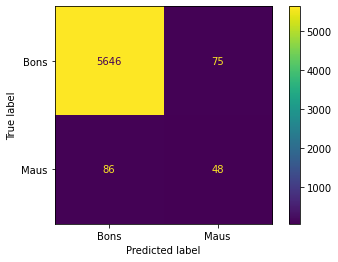

In [ ]:
#rodando o stacked Model
roda_modelo_stacked_(stacked_model, df_registro_clientes_targets, smt)

<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.46524338172502133, pvalue=0.0)
O ROC AUC Score do Stacked Model é: 0.6805634908832867 
 E o recall score é: 0.5970149253731343


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

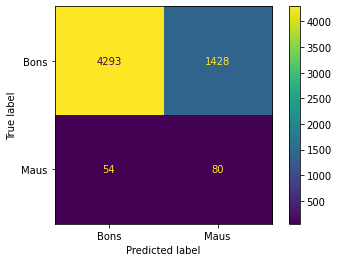

In [ ]:
roda_modelo_stacked_(stacked_model, df_registro_clientes_targets, uns)

<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.9579846285226302, pvalue=0.0)
O ROC AUC Score do Stacked Model é: 0.7669107269108053 
 E o recall score é: 0.3283582089552239


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

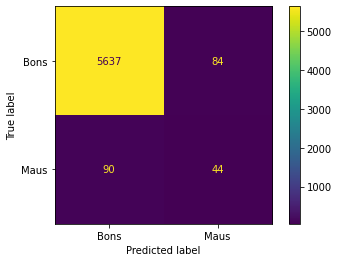

In [ ]:
roda_modelo_stacked_(stacked_model, df_registro_clientes_targets, smk)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.7672583594873039


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.4763450042698548, pvalue=0.0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

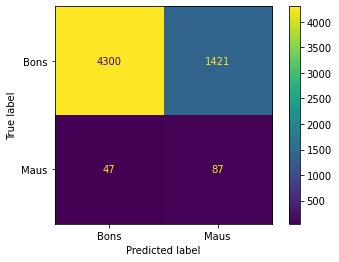


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      5721
           1       0.06      0.65      0.11       134

    accuracy                           0.75      5855
   macro avg       0.52      0.70      0.48      5855
weighted avg       0.97      0.75      0.84      5855



In [ ]:
#Ensembled Method
b_rf_clf = BalancedRandomForestClassifier(random_state=8012587)
pipeline_b_rf_clf = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('b_rf_clf',b_rf_clf)])
roda_modelo(pipeline_b_rf_clf, df_registro_clientes_targets)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC 0.7286900578387558


<IPython.core.display.Javascript object>

KS KstestResult(statistic=0.3439795046968403, pvalue=1.6860851987765255e-307)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

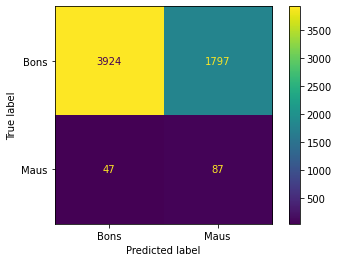


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      5721
           1       0.05      0.65      0.09       134

    accuracy                           0.69      5855
   macro avg       0.52      0.67      0.45      5855
weighted avg       0.97      0.69      0.79      5855



In [ ]:
pipeline_uns2 = Pipeline([('transformer', Transformer(quant_columns, cat_columns)),('uns',uns),("rf_clf_model",rf_clf_model)])
roda_modelo(pipeline_uns2, df_registro_clientes_targets)

Após rodar o Stacked Model com diferentes variações de balanceamento, o **BalancedRandomForest Classifier** ainda se mostrou mais assertivo em classificar o número de Maus.

Vamos agora rodar cross-validations dele.

In [ ]:
roda_modelo_cv(pipeline_b_rf_clf, df_registro_clientes_targets, 5,10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC Médio 0.7522443546742076 Intervalo 0.6965311476553219 - 0.8079575616930933
Recall médio 0.6326600899965386 Intervalo 0.5345452355819704 - 0.7307749444111067


O resultados saíram dentro do que esperávamos, como havíamos adiantado.

Por fim, de forma a dar a maior robustez possível ao modelo, iremos treiná-lo com todos os dados disponíveis e então salvá-lo, salvar mais algumas informações úteis para colocá-lo em Produção e partir para o deploy através da biblioteca Streamlit.

In [ ]:
x = df_registro_clientes_targets.drop(columns=['id_cliente','mau'])
y = df_registro_clientes_targets['mau']

pipeline_b_rf_clf.fit(x,y)

Pipeline(steps=[('transformer',
                 Transformer(cat_columns=['categoria_de_renda', 'estado_civil',
                                          'moradia', 'ocupacao',
                                          'grau_escolaridade', 'tem_carro',
                                          'tem_casa_propria',
                                          'tem_telefone_trabalho',
                                          'tem_telefone_fixo', 'tem_email'],
                             quant_columns=['qtd_filhos', 'rendimento_anual',
                                            'idade', 'tamanho_familia',
                                            'anos_empregado'])),
                ('b_rf_clf',
                 BalancedRandomForestClassifier(random_state=8012587))])

In [ ]:
#salvando o modelo
dump(pipeline_b_rf_clf, 'pipeline_modelo.joblib')

['pipeline_modelo.joblib']

In [ ]:
#salvando as features que precisam ser preenchidas pelo cliente
features = x.columns
dump(features, 'features_a_preencher.joblib')

['features_a_preencher.joblib']

In [ ]:
!pip install pandas==1.1.5

In [ ]:
import pandas as pd
#Por um conflito de versão com o apply do Pandas tivemos que reinstalar a versão 1.1.5 em ordem de poder salvar as cat_options

In [ ]:
#salvando as opções categóricas para preenchimento do cliente
cat_options_a_preencher = df_registro_clientes_targets[categorical_columns].apply(lambda x: x.unique(),axis=0)
dump(cat_options_a_preencher, 'cat_options_a_preencher.joblib')

['cat_options_a_preencher.joblib']

Conclusões e notas sobre Machine Learning no projeto

Em primeiro lugar pudemos verificar que apesar de várias tentativas e configurações diferentes, o problema do desbalanceamento das classes foi muito forte no projeto. O que manteve certo viés no modelo.

Outro ponto que gostaríamos de ressaltar é que nessa vez, provavelmente devido ao viés, um StackedModel não performou melhor do que um modelo comum.

Se desejar volte ao notebook de análise [aqui](https://) inserir link

Agora, acesse o [site](https://share.streamlit.io/enzogolfetti/projeto_concessao_credito_ml/main/streamlit_files/streamlit_app_v1.py) com o modelo em produção deste projeto.